In [1]:
import pandas as pd
import numpy as np

%matplotlib inline

import matplotlib.pylab as plt
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 16, 8

In [8]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv(r"F:\Desktop\Digital Lync\DataSets\Time Series\AirPassengers.csv",
                   index_col = ['Month'],parse_dates = ['Month'],date_parser = dateparse)
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [9]:
ts = data['#Passengers']
ts.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

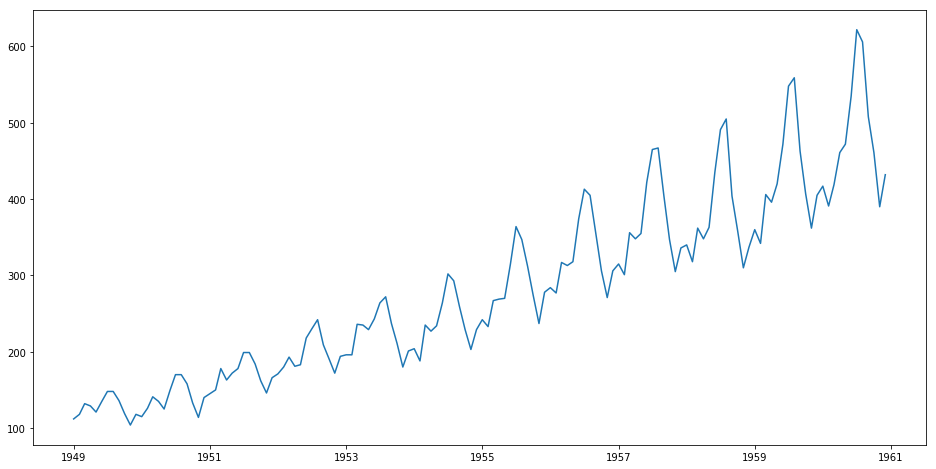

In [10]:
plt.plot(ts)
plt.show()

## We use Dickey-Fuller Test to check the Stationarity

### # Dickey-Fuller Test
This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. Refer this article for details.

In [7]:
from statsmodels.tsa.stattools import adfuller
def stationary(timeseries):
    print("Result of Dickey-Fuller Test\n")
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test-Statistic', 'p-value', '#lags used', 'no. of observations'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)
stationary(ts)

C:\Users\lenovo\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Result of Dickey-Fuller Test

Test-Statistic            0.815369
p-value                   0.991880
#lags used               13.000000
no. of observations     130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


##### the test statistic is way more than the critical values. Note that the signed values should be compared and not the absolute values.

To make a TS stationary, we have to remove the trend and seasonality components
    
    1. to remove trend, we can use moving average

    2. applying transformation first

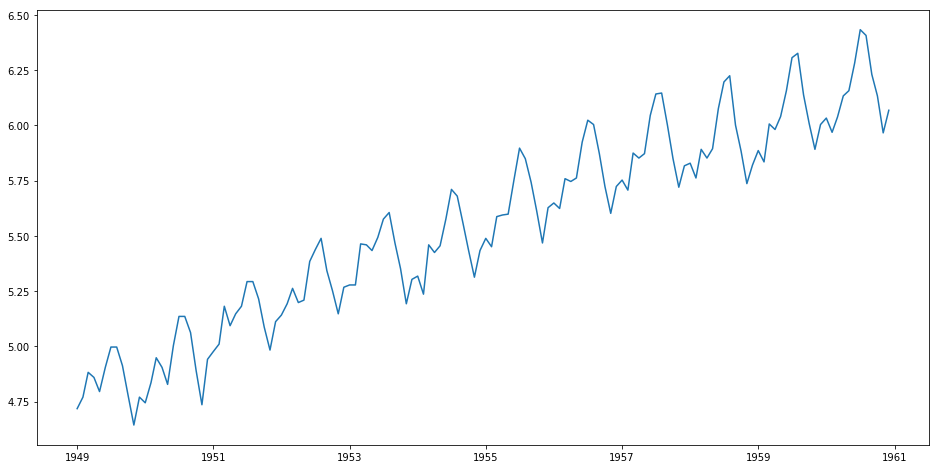

In [8]:
ts_log = np.log(ts)
plt.plot(ts_log)
plt.show()

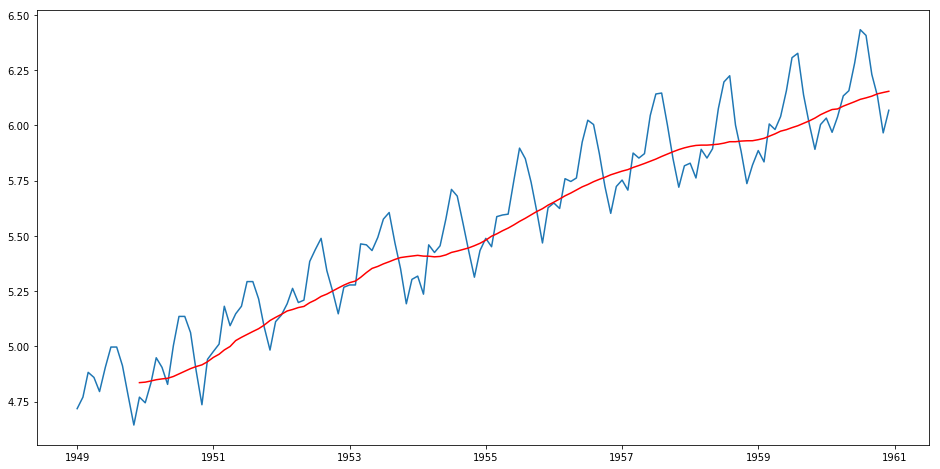

In [9]:
# Moving averages

mov_avg = ts_log.rolling(window = 12).mean()
plt.plot(ts_log) # ts_log is transformation.We are calculating moving averages on transformations
plt.plot(mov_avg, color = 'red')
plt.show()

In [10]:
mov_avg_diff = ts_log - mov_avg
mov_avg_diff.head(14)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
Name: #Passengers, dtype: float64

Result of Dickey-Fuller Test

Test-Statistic           -3.162908
p-value                   0.022235
#lags used               13.000000
no. of observations     119.000000
Critical Value (1%)      -3.486535
Critical Value (5%)      -2.886151
Critical Value (10%)     -2.579896
dtype: float64


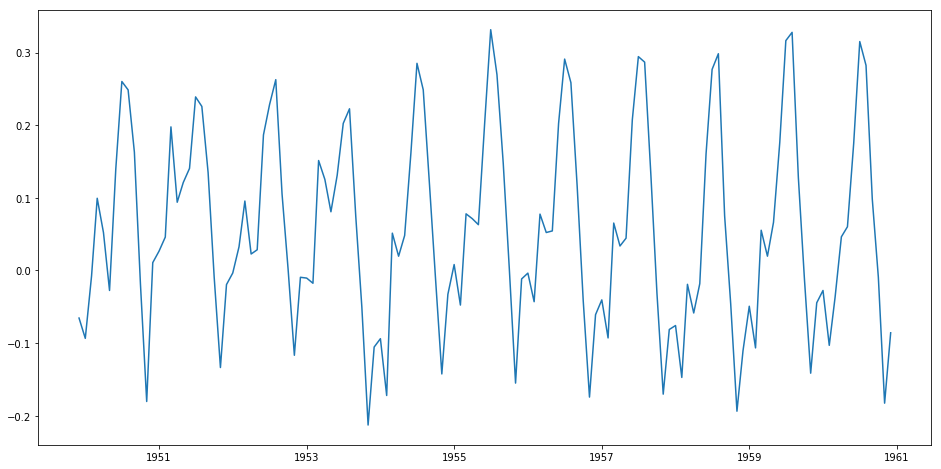

In [11]:
mov_avg_diff.dropna(inplace = True)
stationary(mov_avg_diff)
plt.plot(mov_avg_diff)

## Other ways to remove trend and seasonality are differencing and decomposition

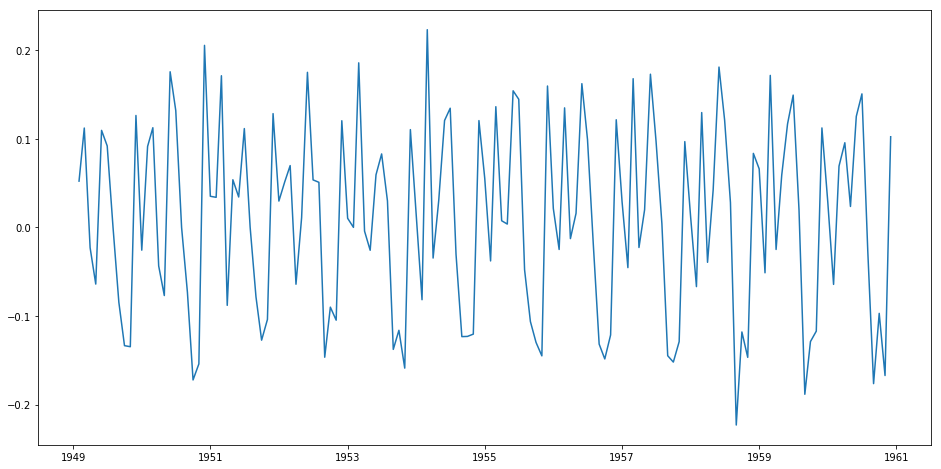

In [12]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)
plt.show()

In [13]:
ts_log_diff.dropna(inplace = True)
stationary(ts_log_diff)

Result of Dickey-Fuller Test

Test-Statistic           -2.717131
p-value                   0.071121
#lags used               14.000000
no. of observations     128.000000
Critical Value (1%)      -3.482501
Critical Value (5%)      -2.884398
Critical Value (10%)     -2.578960
dtype: float64


## Forecasting Time Series

ACF and PACF Plots

In [18]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff, nlags = 20)
lag_pacf = pacf(ts_log_diff, nlags = 20)

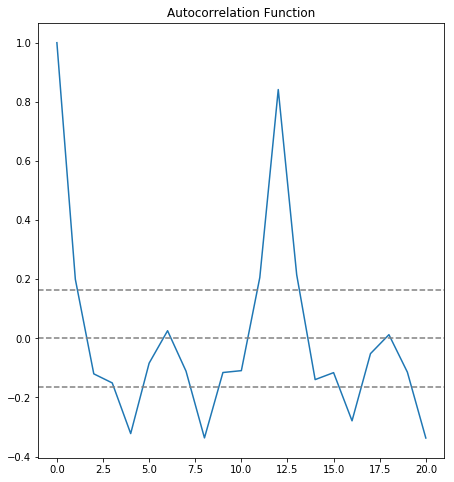

In [29]:
#plot ACF

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.show()

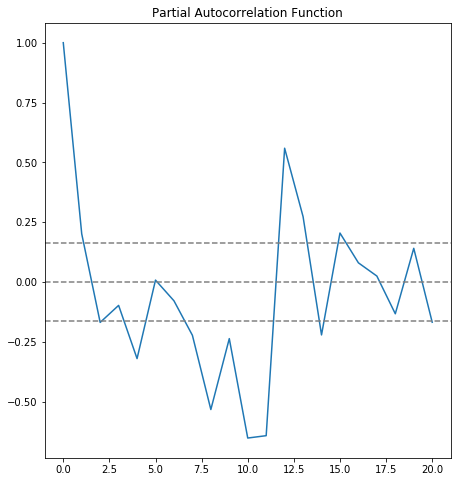

In [20]:
#plot PACF

plt.subplot(121)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()

## Building Models(ARIMA)

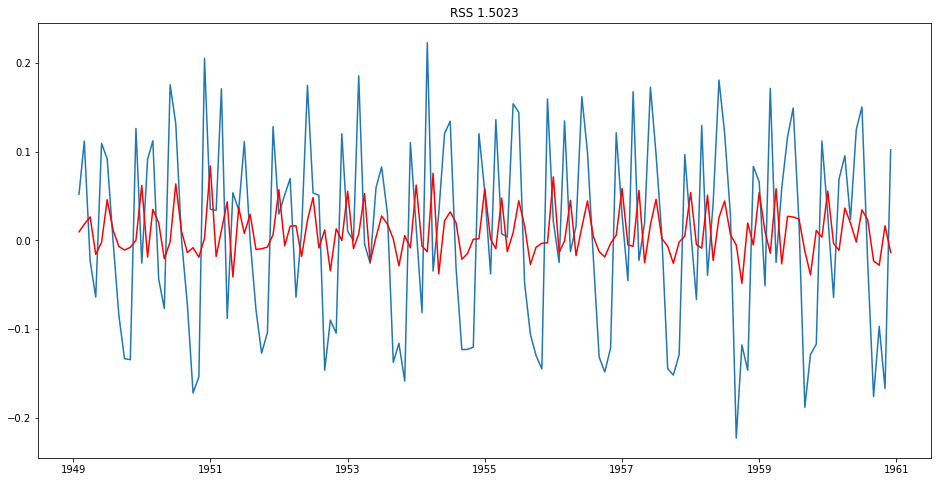

In [21]:
from statsmodels.tsa.arima_model import ARIMA

#AR model

model_AR = ARIMA(ts_log, order = (2, 1, 0))
results_AR = model_AR.fit(disp = -1)
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color = 'red')
plt.title('RSS %.4f' %sum((results_AR.fittedvalues- ts_log_diff) **2))
plt.show()

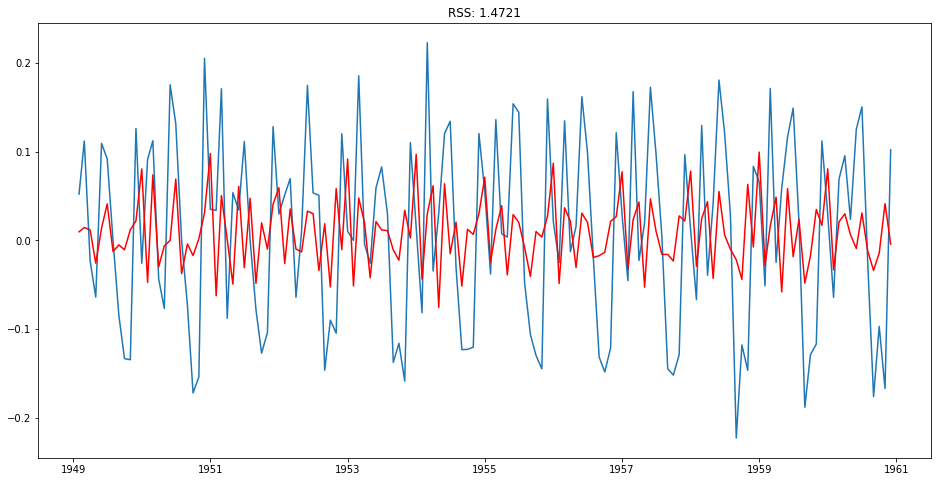

In [22]:
#MA model

model_ma = ARIMA(ts_log, order = (0, 1, 2))
results_MA = model_ma.fit(disp = -1)
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color = 'red')
plt.title('RSS: %.4f' %sum((results_MA.fittedvalues - ts_log_diff) **2))
plt.show()

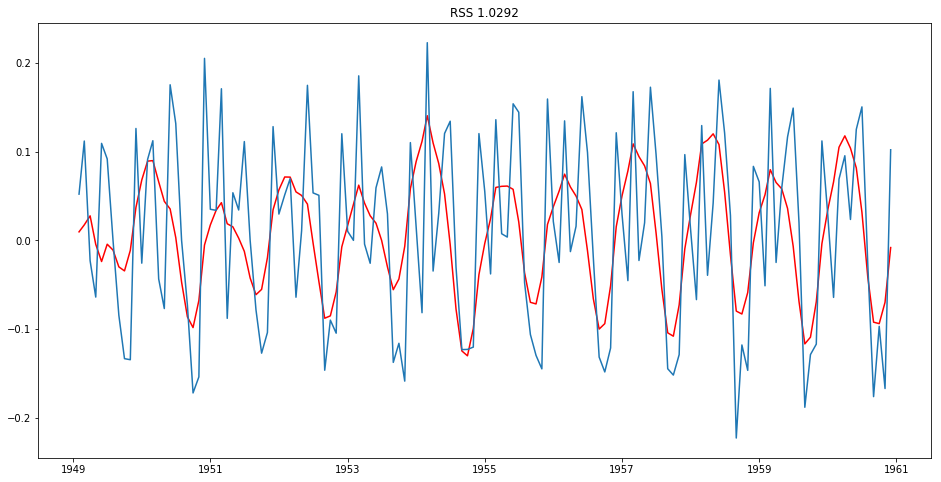

In [23]:
# combined model

model = ARIMA(ts_log, order = (2, 1, 2))
result = model.fit(disp = -1)
plt.plot(result.fittedvalues, color = 'red')
plt.plot(ts_log_diff)
plt.title('RSS %.4f' %sum((result.fittedvalues - ts_log_diff) **2))
plt.show()

In [24]:
pred_ARIMA_diff = pd.Series(result.fittedvalues, copy = True)
pred_ARIMA_diff.head()

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64

###### Notice that these start from ‘1949-02-01’ and not the first month. Why? This is because we took a lag by 1 and first element doesn’t have anything before it to subtract from. The way to convert the differencing to log scale is to add these differences consecutively to the base number. An easy way to do it is to first determine the cumulative sum at index and then add it to the base number. The cumulative sum can be found as:

In [25]:
pred_ARIMA_diff_cumsum = pred_ARIMA_diff.cumsum()
print (pred_ARIMA_diff_cumsum.head())

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


In [28]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)      
predictions_ARIMA_log = predictions_ARIMA_log.add(pred_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

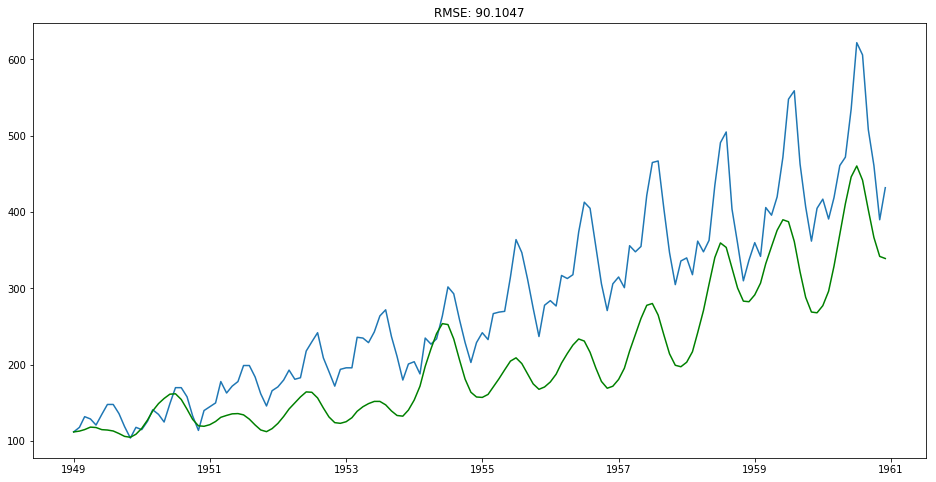

In [27]:
pred_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(pred_ARIMA, color = 'green')
plt.title('RMSE: %.4f'% np.sqrt(sum((pred_ARIMA-ts)**2)/len(ts)))
plt.show()